Plan:
v0.1:
Decision makers: creator
Focal decision: send a follow to a user
Arms: user types

Preparation:
1. Create primary reward: 1st degree follows within a week of receiving the follow
2. Create secondary reward: 2nd degree follows within a week of the primary reward

Recipe:
1. Loop over follows sent by successful creators
2. Use TS to sample the next 

In [1]:
#Run parameters
#used to control every run. Can be user to perfom sensitivity checks
path_dir = r"/Users/../Volumes/Raw/"

low_success = 0.5 #below the median: unsuccessful
high_success = 0.9 #top 10% creators with more followers are deemed successful

low_user_outdegree = 0.25 
high_user_outdegree = 0.75
low_user_activity = 0.25 
high_user_activity = 0.75 

activity_filter = 0
days_delta = 7

In [147]:
import sys  
import pickle
sys.path.insert(0, '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/')
import numpy as np
import src.utils
from collections import Counter
from src.utils import import_dta, import_tracks_dta,\
gen_active_relations, get_fan_interactions_per_week, calculate_avg_monthly_valence,\
gen_active_relations_prob, get_fan_interactions_per_week_prob, stripplot_prob,\
reaction_probability, follower_list, filter_quantile, sample_creators_music,\
gen_outbound_creators
import numpy as np
import datetime
import pandas as pd
from tqdm import tqdm
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import os
from statsmodels.stats.proportion import proportions_ztest
from datetime import datetime, timedelta

In [3]:
def process_date(date):
    '''convert date format like '2013-w09' to '2013-03-04', i.e. the first day of that week'''
    year = date[0:4]
    week = date[6:]
    day = "1"
    date = "{}-{}-1".format(year, week)
    dt = datetime.strptime(date, "%Y-%W-%w")
    return dt

# Data Imports

In [4]:
#affiliations :follows
#favoritings :likes

#used in filtering:
path_dir = r"/Users/../Volumes/Raw/"
tracks = import_tracks_dta(path_dir, "12sample_tracks.dta");

#these are the actions sent to 
follows_sent = import_dta(path_dir, "12sample_affiliations_sent.dta");
comments_sent = import_dta(path_dir, "12sample_comments_made.dta");
shares_sent = import_dta(path_dir, "12sample_reposts_made.dta");
likes_sent = import_dta(path_dir, "12sample_favoritings_made.dta");
messages_sent = import_dta(path_dir, "12sample_messages_sent.dta");

#Used to track information on the 1st degree connections
user_info_1st = import_dta(path_dir, "12sample_1st_deg_user_infos.dta");
user_info_1st.columns = ['user_id', 'type', 'entered_platform'];
user_info = import_dta(path_dir, "12sample_user_infos.dta");

#Used to compute creator's success measure
follows_received = import_dta(path_dir, "12sample_affiliations_received.dta");

%%%%%%%%%% 12sample_tracks.dta %%%%%%%%%%
(56262, 7)
%%%%%%%%%% 12sample_affiliations_sent.dta %%%%%%%%%%
(800913, 3)
%%%%%%%%%% 12sample_comments_made.dta %%%%%%%%%%
(29258, 4)
%%%%%%%%%% 12sample_reposts_made.dta %%%%%%%%%%
(179329, 4)
%%%%%%%%%% 12sample_favoritings_made.dta %%%%%%%%%%
(527701, 4)
%%%%%%%%%% 12sample_messages_sent.dta %%%%%%%%%%
(11091, 3)
%%%%%%%%%% 12sample_1st_deg_user_infos.dta %%%%%%%%%%
(670746, 3)
%%%%%%%%%% 12sample_user_infos.dta %%%%%%%%%%
(35000, 3)
%%%%%%%%%% 12sample_affiliations_received.dta %%%%%%%%%%
(432503, 3)


In [5]:
mask = (tracks.track_available == 1) & (tracks.public == 't')
creator_ids = tracks[mask].user_id.unique()

creators = tracks[(tracks.track_available == 1) & (tracks.public == 't')]

In [6]:
def gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent, messages_sent, creator_ids = creator_ids):
    '''
    Creates dataframe containing the actions that content creators send to users.
        Attributes:
                    follows_sent:  dataframe with the follows sent by the 35k users.
                    shares_sent:   dataframe with the shares sent by the 35k users.
                    likes_sent:    dataframe with the likes sent by the 35k users.
                    comments_sent: dataframe with the comments sent by the 35k users.
                    messages_sent: dataframe with the messages sent by the 35k users.
                    creator_ids:   list with content creator ids. If not none, is used to
                                   filter out activities from non creators.
    '''
    
    follows_sent['outbound_activity'] = 'follow'
    follows_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'song_id' in shares_sent.columns:
        shares_sent.drop(columns=["song_id"])
    shares_sent = shares_sent[['reposter_id', "owner_id", 'created_at']]
    shares_sent['outbound_activity'] = 'share'
    shares_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in likes_sent.columns:
        likes_sent.drop(columns=["track_id"], inplace=True)
    likes_sent['outbound_activity'] = 'like'
    likes_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    if 'track_id' in comments_sent.columns:
        comments_sent.drop(columns=["track_id"], inplace=True)
    comments_sent['outbound_activity'] = 'comment'
    comments_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']

    messages_sent["outbound_activity"] = 'message'
    messages_sent.columns = ['user_id', 'fan_id', 'date_sent', 'outbound_activity']
    df = pd.concat([follows_sent, shares_sent, likes_sent, comments_sent, messages_sent])


    if type(creator_ids) == numpy.ndarray:
        df = df[df['user_id'].isin(creator_ids)]
        
    df['week_yr'] = df.date_sent.dt.strftime('%Y-w%U')
    df = df.loc[df['user_id'] != df['fan_id'],:]

    return df

In [7]:
actions_sent = gen_actions_sent_df(follows_sent, shares_sent, likes_sent, comments_sent,
                                     messages_sent, creator_ids = None)
actions_sent = actions_sent.loc[actions_sent.user_id.isin(creators.user_id.unique())]

active_users_ids = actions_sent.groupby('user_id', as_index = False).size()
mask = active_users_ids['size']>= activity_filter
active_users_ids = active_users_ids[mask].user_id.unique()

In [8]:
def successful_creators_followers(follows_received, base_date = datetime(2016, 5, 30, 0, 0), perc1 = None, perc2 = None, subset_creators = None):
    '''Classifies content creators in successful or unsuccessfull
        Arguments:
                    follows_received: dataframe containing the follows received by content creators
                    base date:        date, in datetime.datetime(YYYY, M, DD, H, M) format, in which the number 
                                      of followers per creator is calculated.
                    perc1:            the threshold used to classify unsuccessful content creators. Creator having 
                                      total followers below the number dictated by this threshold, at the base date,
                                      are classified as unsuccessful 
                    perc2:            the threshold used to classify successful content creators. Creator having 
                                      total followers above the number dictated by this threshold, at the base date,
                                      are classified as successful
                    subset_creators:  a pd.DataFrame containing the creators. If is it available, it will be used to 
                                      filter out non creators and to make sure creators with 0 followers are part of
                                      the resulting dataset.
        
    '''
    print(base_date)

    if 'inbound_activity' not in follows_received.columns:
        follows_received.columns = ['fan_id', 'user_id', 'date_sent']

    mask = (follows_received['date_sent'] < base_date)

    df = follows_received[mask].groupby('user_id', as_index=False).agg({'fan_id': pd.Series.nunique})
    df.columns = ['user_id', 'followers']

    
    if type(subset_creators) == pd.DataFrame:
        print('subsetting...')
        df.set_index('user_id', inplace = True)
        df = df.reindex(subset_creators.user_id.unique())
        df.fillna(0, inplace = True)
        df.reset_index(inplace = True)
        df.columns = ['user_id', 'followers']
        
    mask = df.user_id.isin(active_users_ids)
    df = df[mask]

    low = np.quantile(df.followers, perc1)
    high = np.quantile(df.followers, perc2)

    print("High influencer boundary: {}".format(high))
    print("Low influencer boundary: {}".format(low))

    mask = (df["followers"] <= low) | (df["followers"] >= high)
    
    unsuccessful_creator_ids = df.loc[df["followers"] <= low].user_id.unique()
    successful_creator_ids = df.loc[df["followers"] >= high].user_id.unique()

    return unsuccessful_creator_ids, successful_creator_ids

In [9]:
unsuccessful_ids, successful_ids = successful_creators_followers(follows_received, 
                                                        perc1 = low_success, perc2 = high_success, subset_creators = creators)

2016-05-30 00:00:00
subsetting...
High influencer boundary: 81.0
Low influencer boundary: 13.0


In [10]:
follows_received.columns = ['fan_id', 'user_id', 'date_sent']
followers = follows_received[["fan_id", "user_id", "date_sent"]]
followers.columns = ["fan_id", "user_id", "follower_since"]

follows_sent = follows_sent.merge(followers, right_on = ['user_id', 'fan_id'],
                                      left_on = ['user_id', 'fan_id'], how = 'left')

In [54]:
follows_sent['week_yr_date'] = follows_sent.date_sent.dt.normalize()
mask = (follows_sent.date_sent < follows_sent.follower_since) | (follows_sent.follower_since.isnull())
follows_sent_non_fans =  follows_sent[mask]

# Attribute 1st and 2nd degree rewards to follows sent by creators to users.

1st degree

In [55]:
follows_sent_non_fans['1st_reward'] = ((follows_sent_non_fans['follower_since']>= follows_sent_non_fans['week_yr_date'])&
(follows_sent_non_fans['follower_since'] <=  follows_sent_non_fans['week_yr_date'] + timedelta(days=7))).astype(int)

/var/folders/f2/cgjzt69n5hlgmtsm36p1pztw0000gn/T/ipykernel_27381/2067820225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  follows_sent_non_fans['1st_reward'] = ((follows_sent_non_fans['follower_since']>= follows_sent_non_fans['week_yr_date'])&


2nd degree

Recipe:

-count fans from target that are not yet fans from the creator

-chek how many of those becomes followers of the creator, within a week of the target user becoming a fan

## Helper functions to compute 2nd degree rewards (and failures)

In [199]:
def creator_follower_base_at_t(df, user_id, date):
    '''creates an array with the followers of creator c at time t'''
    
    if df.loc[(df.user_id == user_id)&(df.date_sent <= date)].shape[0] == 0:
        array = []
        
    else:
        array = df.loc[(df.user_id == user_id)&(df.date_sent <= date)]\
        .groupby('user_id', as_index = False)['fan_id'].apply(np.array)[0] 
    
    return set(array)

#unitary test

date = datetime(2016, 5, 30, 0, 0)
followers['date_sent'] = followers.follower_since.dt.normalize()
user_id = 37876767
creator_followers = creator_follower_base_at_t(followers, user_id, date)

In [245]:
def target_follower_base_at_t(df, user_id, date):
    '''creates an array with the followers of target u at time t'''
    
    if df.loc[(df.contact_id == user_id)&(df.created_at <= date)].shape[0] == 0:
        array = []
        
    else:
        array = df.loc[(df.contact_id == user_id)&(df.created_at <= date)]\
        .groupby('contact_id', as_index = False)['fan_id'].apply(np.array)[0] 
    
    return set(array)

#unit test

df_test = pd.read_pickle('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/10362_31300.pkl')
date = datetime(2016, 5, 30, 0, 0)
df_test['date_sent'] = df_test.created_at.dt.normalize()
user_id = 31271
target_followers = target_follower_base_at_t(df_test, user_id, date)

In [248]:
def followers_in_u_not_in_c_at_t(df_follows_creator, df_follows_target, creator_id, target_id, date):
    '''creates an array with the followers of u, at t, that are not yet followers of c'''
    creator_followers = creator_follower_base_at_t(df_follows_creator, creator_id, date)
    target_followers = target_follower_base_at_t(df_follows_target, target_id, date)

    return creator_followers, target_followers, target_followers.difference(creator_set)
    
#unit test

a,b,c =followers_in_u_not_in_c_at_t(followers, df_test,37876767,31271,date)

In [182]:
def get_new_followers_from_c(df, user_id, start_date):
    '''list the followers that c obtained in week t'''
    delta = timedelta(days = 7)
    return df.loc[(df.date_sent >= start_date)&(df.date_sent <= start_date + delta)]\
                                       .groupby('user_id', as_index = False)['fan_id'].apply(np.array)[0]
    

In [48]:
def count_new_followers_of_c_that_follow_u(potential_followers, new_followers):
    '''count the number of new followers of c, at week t and t+7, that are followers of u'''
    
    return len(potential_followers.intersection(new_followers))

In [ ]:
mylist = actions_sent.loc[actions_sent.user_id.isin(successful_ids)].fan_id.unique().tolist()
with open('/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/Data/users_received_actions_from_successful.pkl', 'wb') as f:
    pickle.dump(mylist, f)

In [50]:
follows_sent.head()

,user_id,fan_id,date_sent,outbound_activity,follower_since,week_yr_date
0,37825116,61046,2013-03-01 00:14:58,follow,NaT,2013-03-01
1,37825116,80377,2013-03-01 00:14:58,follow,NaT,2013-03-01
2,37825116,122596,2013-03-01 00:14:58,follow,NaT,2013-03-01
3,37825116,133935,2013-03-01 00:14:58,follow,NaT,2013-03-01
4,37825116,165779,2013-03-01 00:14:58,follow,NaT,2013-03-01


# Data import

In [134]:
import os

# folder path
dir_path = r'/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/'

# list to store files
dict_paths = {}
# Iterate directory
for path in os.listdir(dir_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        if path != '.DS_Store':
            dict_paths[(int(path.split("_",1)[0]),int(path.split("_",1)[1][:-4]))] = path
        else:
            pass

In [138]:
def which_file(user_id):
    return dict_paths[[item for item in dicta.keys() if (user_id>= item[0])&(user_id<=item[1])][0]]

In [203]:
import pandas as pd
pd.options.mode.chained_assignment = None

In [593]:
follows_sent_non_fans['follower_since_day'] = follows_sent_non_fans['follower_since'].dt.normalize()

In [596]:
df = follows_sent_non_fans.copy()
df = df.loc[df.user_id.isin(successful_ids)]
df.sort_values('fan_id', inplace = True)
df["2nd_degree_successes"] = np.nan
df["2nd_degree_failures"]  = np.nan
delta = timedelta(days = 7)
user_followers = followers.loc[followers.user_id.isin(successful_ids)]
old_filename = 'mock_name'

for i in tqdm(range(df.shape[0])):
    if df.iloc[i]['1st_reward'] == 1:
        start_date     = df.iloc[i].follower_since_day
        user_id        = df.iloc[i].user_id
        fan_id         = df.iloc[i].fan_id
        new_filename   = which_file(fan_id)

        if old_filename != new_filename:
            target_followers = pd.read_pickle(
                '/Users/caiorego/Desktop/BDS/RA/Seeding-Bandits/indegree/follower_list/user_followers/MAB_pre_aggregations/{}'\
                .format(new_filename))

        creator_followers_t, user_followers_t, potential_followers =\
            followers_in_u_not_in_c_at_t(user_followers, target_followers, user_id, fan_id, start_date)

        new_followers = get_new_followers_from_c(user_followers, user_id, start_date)

        followers_obtained_from_u = count_new_followers_of_c_that_follow_u(potential_followers, new_followers)
        #print(followers_obtained_from_u)

        df.iloc[i, -2] = followers_obtained_from_u

        df.iloc[i, -1] = len(potential_followers) - df.iloc[i]["2nd_degree_successes"]

        old_filename = new_filename
    else:
        pass
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102855/102855 [22:12<00:00, 77.20it/s]


In [597]:
df['user_type'] = df.fan_id.apply(lambda x: 'f_a' if x in f_a_ids else 
                          ('Hermit' if x in hermit_ids else
                          ('Observer' if x in observer_ids else
                          ('w_a' if x in w_a_ids else 'other'))))

df['creator_type'] = df.user_id.apply(
                               lambda x: 'successful' if x in successful_ids else 
                               ('unsuccessful' if x in unsuccessful_ids else 'other'))

In [599]:
df.to_csv('follwers_1st_2nd_reward')

In [761]:
df = pd.read_csv('follwers_1st_2nd_reward', index_col = 0)

For i in range(follows_sent):
-sample user type from betas:
-samples follow from pool:
-update arms with sample obs:

In [762]:
import numpy as np

class ThompsonSamplingBandit:
    def __init__(self, arms, df_pool):
        self.df_pool = df_pool
        self.arms = arms
        self.num_arms = len(arms)
        self.alpha1 = {arm: 1 for arm in arms}
        self.beta1 = {arm: 10 for arm in arms}
        self.alpha2 = {arm: 1 for arm in arms}
        self.beta2 = {arm: 20 for arm in arms} 
        self.combined_alpha = None
        self.combined_beta = None

    def pull_arm(self):
        # Sample a success probability for each arm using Beta distribution
        S = {arm: (self.alpha1[arm] * self.alpha2[arm])/(
            (self.alpha1[arm]+self.beta1[arm])*(self.alpha2[arm]+self.beta2[arm])
            ) for arm in self.arms}
        
        T ={arm: ((self.alpha1[arm]*self.alpha2[arm]*(self.alpha1[arm]+1)*(self.alpha2[arm]+1))
                  /((self.alpha1[arm]+self.beta1[arm])*(self.alpha2[arm]+self.beta2[arm])*
                    (self.alpha1[arm]+self.beta1[arm]+1)*(self.alpha2[arm]+self.beta2[arm]+1))
                 ) for arm in self.arms}

        
        self.combined_alpha = {arm : (S[arm]/(T[arm]-S[arm]**2)) for arm in self.arms}
        self.combined_beta = {arm : (((1-S[arm])*(S[arm]-T[arm]))/(T[arm]-S[arm]**2)) for arm in self.arms}
        
        #print(self.combined_alpha)
        #print(self.combined_beta)
        
        success_probs = {
            arm: np.random.beta(self.combined_alpha[arm], self.combined_beta[arm])
            for arm in self.arms
        }

        # Choose the arm with the highest success probability
        arm = max(success_probs, key=success_probs.get)

        # Simulate pulling the chosen arm and getting a reward
        reward1, reward2, failure2 = self._get_reward(arm)

        # Update success or failure counts based on the reward
        if reward1 == 1:
            self.alpha1[arm] += 1
            self.alpha2[arm] += reward2
            self.beta2[arm] += failure2
        else:
            self.beta1[arm] += 1
        

        #print('User_type:{} \n {} follow \n 2nd follows{}'.format(arm, reward1, reward2))

    def _get_reward(self, arm):
        # Simulate the reward based on the chosen arm
        # You can replace this with your own reward distribution logic
        sample = self.df_pool.loc[self.df_pool.user_type == arm].sample(1)

        reward1 = sample['1st_reward'].values[0] 
        reward2 = sample['2nd_degree_successes'].values[0]
        failure2 = sample['2nd_degree_failures'].values[0]

        return reward1, reward2, failure2
    
    def _get_moments(self):
        #estimate mean and variance
        mean_1 = {arm: {'mean_1' : self.alpha1[arm]/(self.alpha1[arm]+self.beta1[arm])} for arm in arms}
        var_1  = {arm: {'var_1' : (self.alpha1[arm]*self.beta1[arm])/
                                     ((self.alpha1[arm]+self.beta1[arm])**2*
                                      (self.alpha1[arm]+self.beta1[arm]+1))} for arm in arms}
        
        mean_2 = {arm: {'mean_2' : self.alpha2[arm]/(self.alpha2[arm]+self.beta2[arm])} for arm in arms}
        var_2  = {arm: {'var_2' :(self.alpha2[arm]*self.beta2[arm])/
                                     ((self.alpha2[arm]+self.beta2[arm])**2*
                                      (self.alpha2[arm]+self.beta2[arm]+1))} for arm in arms}
        
        mean_comb = {arm: {'mean_comb' : self.combined_alpha[arm]/(self.combined_alpha[arm]+self.combined_beta[arm])} for arm in arms}
        var_comb  = {arm:  {'var_comb' :(self.combined_alpha[arm]*self.combined_beta[arm])/
                                     ((self.combined_alpha[arm]+self.combined_beta[arm])**2*
                                      (self.combined_alpha[arm]+self.combined_beta[arm]+1))} for arm in arms}
        
        combined_dict = {}
        
        for entry in mean_1.keys():
            combined_dict[entry] = {**mean_1[entry], **mean_2[entry], **mean_comb[entry],
                                **var_1[entry], **var_2[entry], **var_comb[entry]}
        
        return combined_dict

In [766]:
# Create a Thompson Sampling Multi-Armed Bandit with 3 arms
num_iterations = df.shape[0]
arms = ["f_a", "w_a", "Observer", "Hermit"]
bandit = ThompsonSamplingBandit(arms, df)
estimates = {}
dfs = {}

df_f_a = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2", "mean_comb", "var_1","var_2","var_comb"])
df_hermit = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2", "mean_comb", "var_1","var_2","var_comb"])
df_observer = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2", "mean_comb", "var_1","var_2","var_comb"])
df_w_a = pd.DataFrame(index=range(num_iterations), columns=["mean_1","mean_2", "mean_comb", "var_1","var_2","var_comb"])

# Pull arms for multiple iterations
for i in tqdm(range(num_iterations)):
    bandit.pull_arm()
    estimates_dict = bandit._get_moments()
    
    for key, values in estimates_dict.items():
        data = pd.DataFrame(values, index=[0])
        dfs[key] = data

    # Access individual DataFrames by key
    df_f_a.iloc[i] = dfs['f_a']
    df_hermit.iloc[i] = dfs['Observer']
    df_observer.iloc[i] = dfs['Hermit']
    df_w_a.iloc[i] = dfs['w_a']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 102855/102855 [13:17<00:00, 128.91it/s]


# Sanity Checks

In [681]:
#plot learning

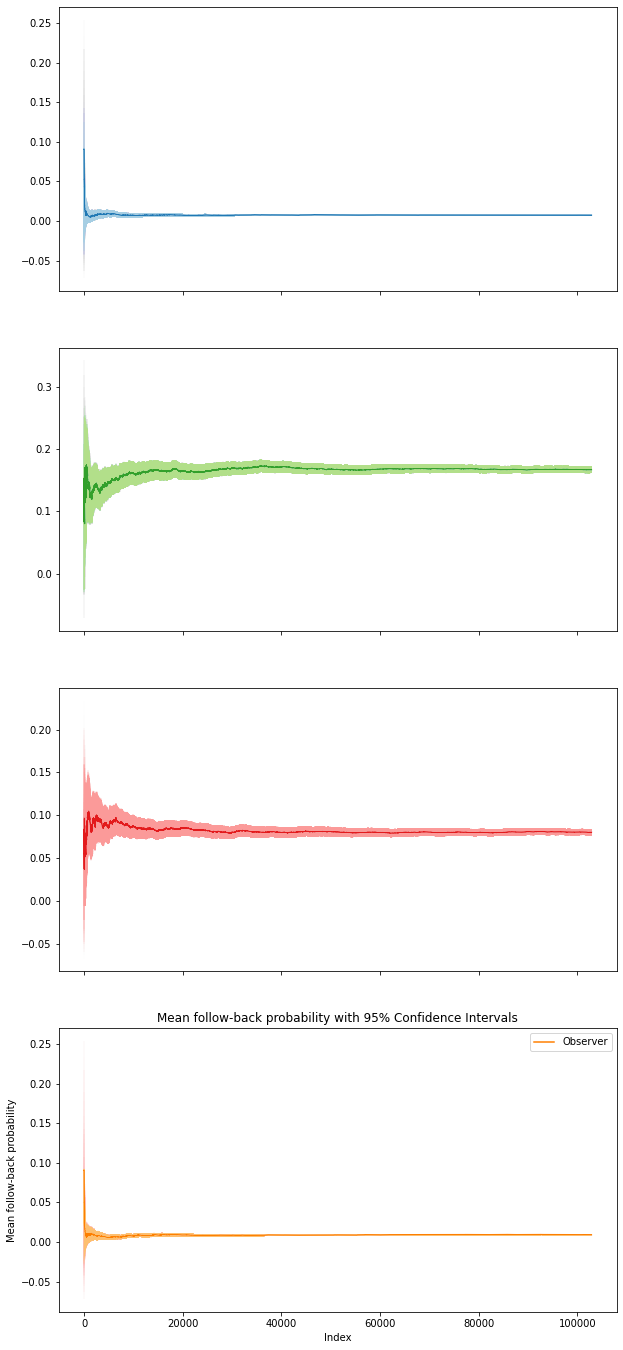

In [767]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
dfs = [df_f_a, df_w_a, df_hermit, df_observer]
names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# Set the confidence level (95% in this case)
confidence_level = 0.95

# Set up the figure with multiple subplots
fig, axs = plt.subplots(len(dfs), figsize=(10, 6 * len(dfs)), sharex=True)

# Loop through each dataframe and create individual subplots
for idx, (ax, df_) in enumerate(zip(axs, dfs)):
    mean_values = df_['mean_1']
    var_values = df_['var_1']

    # Calculate the standard error
    standard_error = var_values**(1/2)

    # Calculate the critical value for the normal distribution
    z_critical = norm.ppf((1 + confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * standard_error

    # Plot the mean values and confidence intervals for each dataframe
    color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
    color2 = plt.cm.Paired(2*idx)
    
    ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
    ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
                color=color2, alpha=0.003)

# Customize the plot
ax.set_xlabel('Index')
ax.set_ylabel('Mean follow-back probability')
ax.set_title('Mean follow-back probability with 95% Confidence Intervals')
ax.legend()

# Show the plot
plt.show()

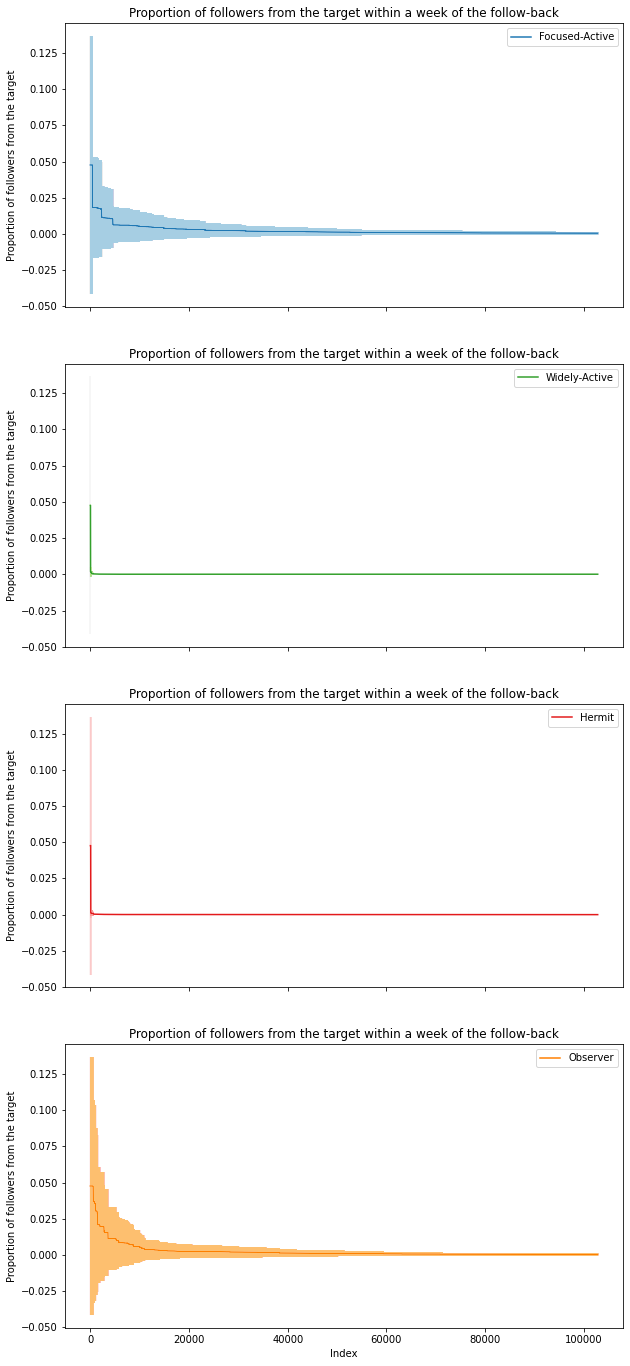

In [768]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
dfs = [df_f_a, df_w_a, df_hermit, df_observer]
names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# Set the confidence level (95% in this case)
confidence_level = 0.95

# Set up the figure with multiple subplots
fig, axs = plt.subplots(len(dfs), figsize=(10, 6 * len(dfs)), sharex=True)

# Loop through each dataframe and create individual subplots
for idx, (ax, df_) in enumerate(zip(axs, dfs)):
    mean_values = df_['mean_2']
    var_values = df_['var_2']

    # Calculate the standard error
    standard_error = var_values**(1/2)

    # Calculate the critical value for the normal distribution
    z_critical = norm.ppf((1 + confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * standard_error

    # Plot the mean values and confidence intervals for each dataframe
    color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
    color2 = plt.cm.Paired(2*idx)
    
    ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
    ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
                color=color2, alpha=0.002)

    # Customize the plot
    ax.set_ylabel('Proportion of followers from the target')
    ax.set_title('Proportion of followers from the target within a week of the follow-back')
    ax.legend()
ax.set_xlabel('Index')
# Show the plot
plt.show()

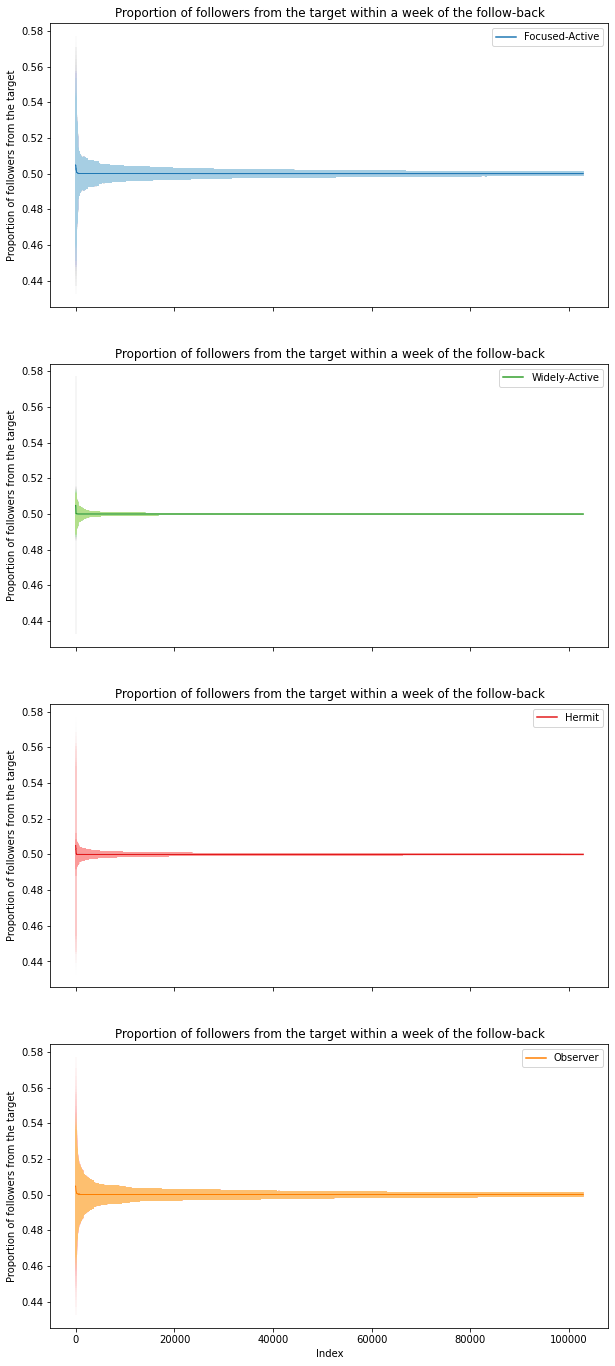

In [769]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming you have already loaded the data into the 'df_f_a', 'df_f_b', 'df_f_c', and 'df_f_d' DataFrames
dfs = [df_f_a, df_w_a, df_hermit, df_observer]
names = ['Focused-Active', 'Widely-Active', 'Hermit', 'Observer']

# Set the confidence level (95% in this case)
confidence_level = 0.95

# Set up the figure with multiple subplots
fig, axs = plt.subplots(len(dfs), figsize=(10, 6 * len(dfs)), sharex=True)

# Loop through each dataframe and create individual subplots
for idx, (ax, df_) in enumerate(zip(axs, dfs)):
    mean_values = df_['mean_comb']
    var_values = df_['var_comb']

    # Calculate the standard error
    standard_error = var_values**(1/2)

    # Calculate the critical value for the normal distribution
    z_critical = norm.ppf((1 + confidence_level) / 2)

    # Calculate the margin of error
    margin_of_error = z_critical * standard_error

    # Plot the mean values and confidence intervals for each dataframe
    color = plt.cm.Paired(2*idx+1)  # Use a different color for each dataframe
    color2 = plt.cm.Paired(2*idx)
    
    ax.plot(mean_values, label='{}'.format(names[idx]), color=color)
    ax.errorbar(mean_values.index, mean_values, yerr=margin_of_error,
                color=color2, alpha=0.002)

    # Customize the plot
    ax.set_ylabel('Proportion of followers from the target')
    ax.set_title('Proportion of followers from the target within a week of the follow-back')
    ax.legend()
ax.set_xlabel('Index')
# Show the plot
plt.show()